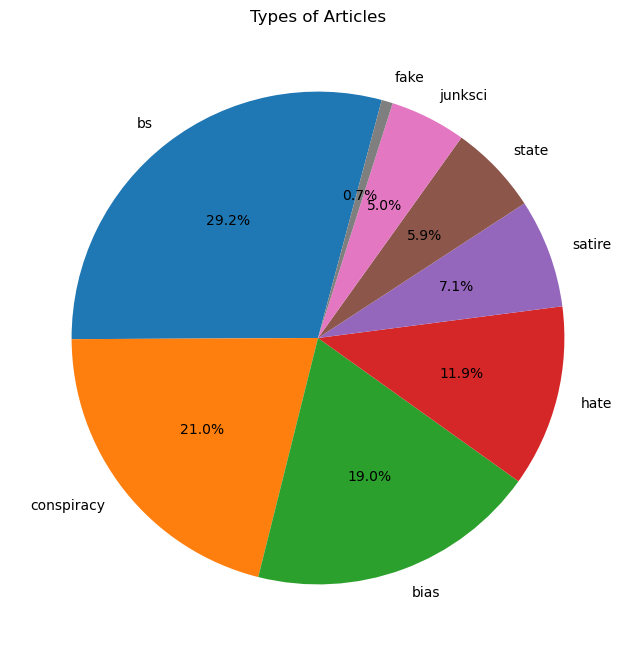

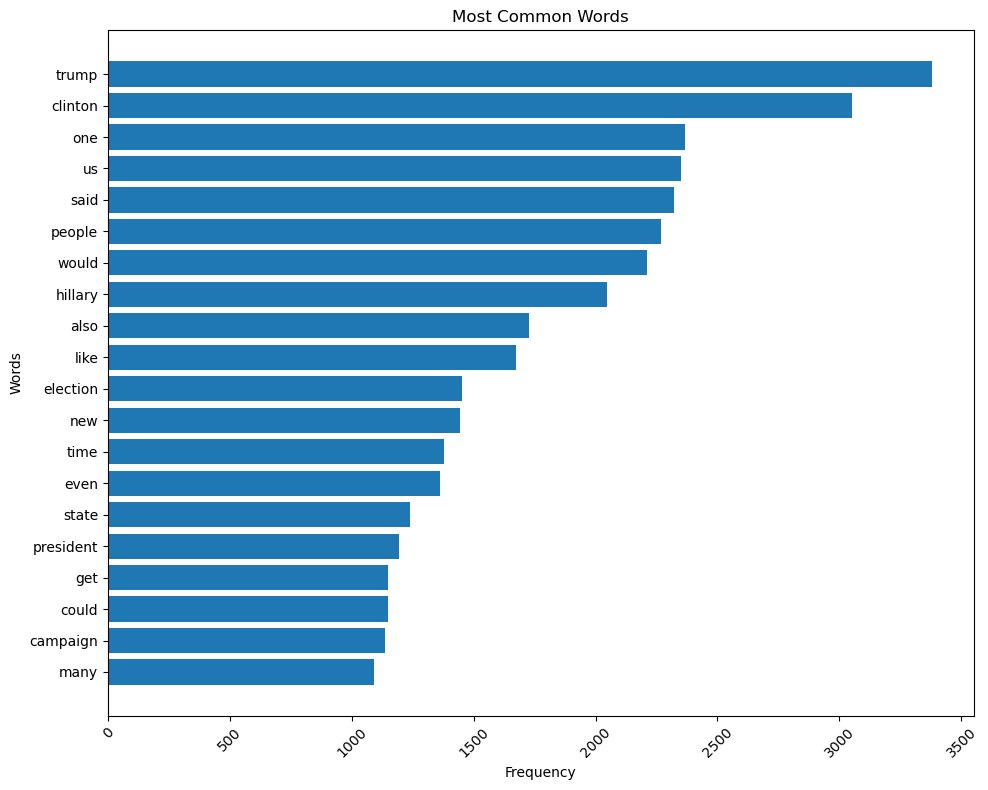

AdaBoost Accuracy: 0.976
RandomForest Accuracy: 0.836


In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from IPython.core.display import HTML

# Load and clean data
df = pd.read_csv(r"E:\brain.project\Fake News Detection\news_articles.csv", encoding="latin", index_col=0)
df.dropna(inplace=True)

df['type'].replace({'Real': 0, 'Fake': 1}, inplace=True)
df['text_without_stopwords'].fillna('', inplace=True)

# Visualizing data distribution
df['type'].value_counts().plot.pie(figsize=(8, 8), autopct='%1.1f%%', startangle=75)
plt.title('Types of Articles')
plt.axis('off')
plt.show()

# WordCloud-like visualization using Counter and matplotlib
def generate_wordcloud(text):
    # Combine all text and split it into words
    all_text = ' '.join(text)
    words = all_text.split()

    # Count the frequency of each word
    word_counts = Counter(words)

    # Get the most common words (top 20 for readability)
    common_words = word_counts.most_common(20)

    # Plotting the word frequencies
    plt.figure(figsize=(10, 8))  # Adjusted figure size for better spacing
    plt.barh([item[0] for item in common_words], [item[1] for item in common_words])
    plt.title('Most Common Words')
    plt.xlabel('Frequency')
    plt.ylabel('Words')
    
    # Rotate y-axis labels for better readability
    plt.gca().invert_yaxis()
    plt.xticks(rotation=45)  # Rotate the x-axis labels if needed
    plt.tight_layout()  # Ensure the layout doesn't cut off any labels
    plt.show()

generate_wordcloud(df['text_without_stopwords'])

# Bar Plot Visualization
df['hasImage'].fillna('Unknown', inplace=True)
fig = px.bar(df, x='hasImage', y='type', title='Articles with Images vs. Type')
fig.show()

# Convert function for rendering images in HTML
def convert(path):
    return '<img src="'+ path + '" width="80">'

# Creating df_sources DataFrame with site_url, label, and main_img_url
df_sources = df[['site_url', 'label', 'main_img_url']]

# Selecting Real and Fake articles to display (you can adjust the indices as needed)
df_r = df_sources.loc[df['label'] == 'Real'].iloc[6:10, :]
df_f = df_sources.loc[df['label'] == 'Fake'].head(6)

# Clean HTML output for table with images
def create_html_table(df):
    # Create an HTML table with image tags rendered properly
    html_output = '<table border="1" style="border-collapse: collapse; width: 100%;">'
    html_output += '<thead><tr><th>Author</th><th>Site URL</th><th>Label</th><th>Image</th></tr></thead><tbody>'
    
    for idx, row in df.iterrows():
        author = row['site_url']
        label = row['label']
        img_tag = convert(row['main_img_url'])
        html_output += f'<tr><td>{author}</td><td>{row["site_url"]}</td><td>{label}</td><td>{img_tag}</td></tr>'
    
    html_output += '</tbody></table>'
    return html_output

# Generate HTML for Real articles
html_output_real = create_html_table(df_r)

# Save the HTML output to a file
with open('real_articles_table.html', 'w') as f:
    f.write(html_output_real)

# Optionally display the HTML within a Jupyter environment
# HTML(html_output_real)

# Model Training
df['source'] = df['site_url'].astype(str) + " " + df['text_without_stopwords']

# Model Training
y = df['type']
x = df['source']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

tfidf_vect = TfidfVectorizer(stop_words='english')
tfidf_train = tfidf_vect.fit_transform(x_train)
tfidf_test = tfidf_vect.transform(x_test)

# AdaBoost Classifier
adab = AdaBoostClassifier(DecisionTreeClassifier(max_depth=10), n_estimators=5, random_state=1)
adab.fit(tfidf_train, y_train)
y_pred_adab = adab.predict(tfidf_test)
print(f"AdaBoost Accuracy: {metrics.accuracy_score(y_test, y_pred_adab):.3f}")

# RandomForest Classifier
rfc = RandomForestClassifier(n_estimators=100, random_state=0)
rfc.fit(tfidf_train, y_train)
y_pred_rfc = rfc.predict(tfidf_test)
print(f"RandomForest Accuracy: {metrics.accuracy_score(y_test, y_pred_rfc):.3f}")
